In [9]:
import os
import pretty_midi
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## DataLoad

In [2]:
train = pd.read_csv("../dataset/split/train.csv", index_col=0)
val= pd.read_csv("../dataset/split/val.csv", index_col=0)
test= pd.read_csv("../dataset/split/test.csv", index_col=0)
train_val = pd.concat([train, val], axis=0)

In [3]:
def get_midi_df(fn):
    midi_data = pretty_midi.PrettyMIDI(fn)
    midi_data.remove_invalid_notes()
    midi_list = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            start = note.start
            end = note.end
            pitch = note.pitch
            velocity = note.velocity
            midi_list.append([start, end, pitch, velocity])
            
    midi_list = sorted(midi_list, key=lambda x: (x[0], x[2]))
    midi_df = pd.DataFrame(midi_list, columns=['start', 'end', 'pitch', 'velocity'])
    midi_df['note_length'] = midi_df['end'] - midi_df['start']
    return midi_df

In [4]:
def get_song_level_feature(fn):
    results = {}
    midi_df = get_midi_df(fn)
    results['note_length_mean'] = midi_df['note_length'].mean()
    results['velocity_mean'] = midi_df['velocity'].mean()
    return results

In [5]:
def _feature_extractor(train_val):
    feature_list = []
    for fname in train_val.index:
        midi_features = get_song_level_feature(os.path.join(midi_path, fname + ".mid"))
        matlab_features = pd.read_csv(os.path.join(matlab_path, fname + ".csv"))
        midi_features['keyname'] = matlab_features['keyname'].item()
        midi_features['beatNoteDensity'] = matlab_features['beatNoteDensity'].item()
        feature_list.append(midi_features)
    return feature_list

In [6]:
midi_path = "../../dataset/PEmoDataset/midis/"
matlab_path = "../dataset/matlab_feature/"
train_val_list = _feature_extractor(train_val)
test_list = _feature_extractor(test)

In [11]:
df_viz = pd.DataFrame(train_val_list + test_list, index=list(train_val.index) + list(test.index))

In [13]:
labels = [i.split("_")[0] for i in df_viz.index]
df_viz['label'] = labels

In [14]:
df_viz

,note_length_mean,velocity_mean,keyname,beatNoteDensity,label
Q4_rW1I58_lMEg_2,0.672347,39.270408,c,3.281188,Q4
Q1_7yW9c7t8Hq0_3,0.504668,89.361396,g,6.150277,Q1
Q4_IgpNyJVWcBo_0,1.156261,48.728033,A,2.181141,Q4
Q1_Y5JcZQ0xg4Y_2,0.569784,71.738019,A#,5.287902,Q1
Q3_QJlnTN7HRwE_2,1.361091,50.616822,C,1.938563,Q3
...,...,...,...,...,...
Q2_rEz0D3VohFA_2,0.812093,84.312384,f#,5.561337,Q2
Q2__FVzelKlBFs_0,0.396752,94.119748,c#,9.077788,Q2
Q1_bIx4DwkZxFY_0,1.009453,64.417808,E,2.579211,Q1
Q2_9v2WSpn4FCw_5,0.389840,82.870423,g,5.722175,Q2


In [27]:
def _get_vio(variable, df_midi):
    df_use = df_midi[[variable,'label']]
    ax = sns.violinplot(x=df_use['label'], y=df_use[variable], data=df_use, order=["Q1","Q2","Q3","Q4"])
    ax.figure.savefig(variable + ".png", dpi=300)
    plt.show()

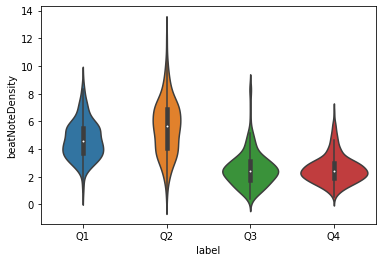

In [30]:
_get_vio("beatNoteDensity", df_viz)

Q1
Q2
Q3
Q4


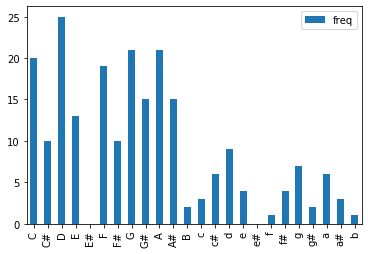

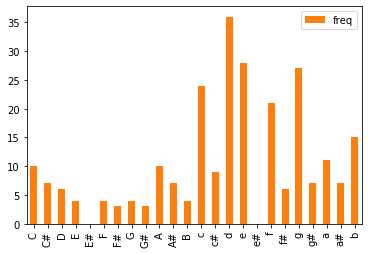

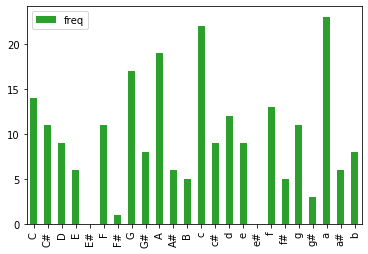

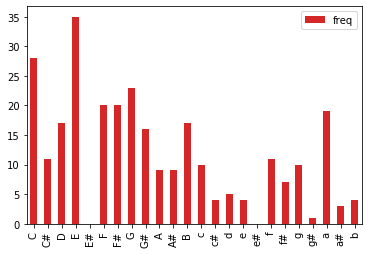

In [34]:
from collections import Counter
major = ['C','C#','D',"E","E#",'F','F#','G','G#','A','A#','B']
minor = [i.lower() for i in major]
keyorder = major + minor

labels = ["Q1","Q2","Q3","Q4"]
color = ['tab:blue','tab:orange','tab:green','tab:red']
results = {}
for label,c in zip(labels,color):
    print(label)
    condition = df_viz[df_viz['label'] == label]
    count_dict = Counter(condition['keyname'].to_list())
    sort_dict = {i:count_dict[i] for i in keyorder}
    df_count = pd.DataFrame(sort_dict.values(), index=sort_dict.keys(), columns=['freq'])
    fig = df_count.plot.bar(color=c).get_figure()
    fig.savefig(label + '.png', dpi=300)

# ML Classifier

In [8]:
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix

In [9]:
def _get_labels(label_quad, cls_type):
    if cls_type == "AV":
        results = np.array(label_quad)
    elif cls_type == "A":
        labels = []
        for label in label_quad:
            if label in ['Q1','Q2']:
                labels.append('HA')
            elif label in ['Q3','Q4']:
                labels.append('LA')
        results = np.array(labels)
    elif cls_type == "V":
        labels = []
        for label in label_quad:
            if label in ['Q1','Q4']:
                labels.append('HV')
            elif label in ['Q2','Q3']:
                labels.append('LV') 
        results = np.array(labels)
    return results

def _get_train_test(train_val_list, test_list, cls_type = "AV"):
    m_x_train = pd.DataFrame(train_val_list)
    m_x_train = pd.concat([m_x_train, pd.get_dummies(m_x_train.keyname)],axis=1).drop(columns=['keyname'])
    m_x_test = pd.DataFrame(test_list)
    m_x_test = pd.concat([m_x_test, pd.get_dummies(m_x_test.keyname)],axis=1).drop(columns=['keyname'])
    
    m_y_train = list(train_val['label'])
    m_y_test = list(test['label'])
    m_y_train = _get_labels(m_y_train, cls_type)  
    m_y_test = _get_labels(m_y_test, cls_type)  
    return m_x_train, m_y_train, m_x_test, m_y_test

In [10]:
def _get_results(cls_type = "AV"):
    m_x_train, m_y_train, m_x_test, m_y_test = _get_train_test(train_val_list, test_list, cls_type = cls_type)
    clf = LogisticRegression(random_state=42).fit(m_x_train, m_y_train)
    return clf.score(m_x_test, m_y_test)

In [11]:
_get_results(cls_type = "AV"), _get_results(cls_type = "A"), _get_results(cls_type = "V")

/MIDI_Emotion_Classification/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/MIDI_Emotion_Classification/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

(0.660377358490566, 0.9245283018867925, 0.6509433962264151)